# Simple CNN with regression
Had 101 categorical in the first cnn and lstm I did, so gonna try regression this time

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import backend as k
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Dense, Conv1D, Dropout
from keras.layers import MaxPooling1D, Flatten, Embedding, LSTM
from keras.models import Sequential
import spacy
import nltk
import en_core_web_md

Using TensorFlow backend.


In [2]:
ign_df = pd.read_pickle('ign_data/ign_data_pass_three.pkl')

ign_df = ign_df.loc[ign_df['review_score']!='null']
ign_df.reset_index(drop=True)

print(ign_df.shape)
ign_df.head()

(11072, 19)


,links,rough_review_body,cleaned_review_body,review_summary_rough,review_score,tags,categories,modified_date,published_date,author_name,tag_list,categories_list,review_title,review_body_corpus,review_score_float,number_character_review,number_words_review,polarity,subjectivity
1,https://www.ign.com/articles/2011/07/19/warham...,"\u003csection class=\""article-page\""\u003e\u00...",'Warhammer 40K: Kill Team might be unfortun...,"""And \""also-ran\"" hangs all over Warhammer 40K...",6.5,":[""review"",""blogroll"",""event-essentials"",""hot""...",":[""ign"",""ps3"",""xbox-360"",""xbox-live""],",2011-10-18T05:59:32+0000,2011-07-19T19:47:00+0000,"""Arthur Gies""","[review, blogroll, event-essentials, hot, lega...","[ign, ps3, xbox-360, xbox-live, ]","""Warhammer 40K: Kill Team Review""",warhammer 40k kill team might be unfortunat...,6.5,3705,642,0.062923,0.433371
2,https://www.ign.com/articles/2011/07/20/call-o...,"\u003csection class=\""article-page\""\u003eThe ...",The Call of Juarez franchise always intereste...,"""Call of Juarez: The Cartel is a poor change o...",4.5,":[""review"",""blogroll"",""call-of-juarez-the-cart...",":[""ign"",""pc"",""ps3"",""xbox-360""],",2011-10-18T06:02:02+0000,2011-07-20T00:14:00+0000,"""Anthony Gallegos""","[review, blogroll, call-of-juarez-the-cartel, ...","[ign, pc, ps3, xbox-360, ]","""Call of Juarez: The Cartel Review""",the call of juarez franchise always intereste...,4.5,3770,648,-0.016471,0.457898
3,https://www.ign.com/articles/2011/07/20/captai...,"\u003csection class=\""article-page\""\u003eThe ...",The majority of movie games are just awful. S...,"""Captain America: Super Soldier is a mediocre ...",5.5,":[""review"",""blogroll"",""legacy"",""wii"",""games"",""...",":[""ign"",""wii""],",2011-10-18T06:02:20+0000,2011-07-20T00:43:00+0000,"""Audrey Drake""","[review, blogroll, legacy, wii, games, captain...","[ign, wii, ]","""Captain America: Super Soldier Wii Review""",the majority of movie games are just awful st...,5.5,2675,474,-0.003842,0.544458
4,https://www.ign.com/articles/2011/07/20/quiz-c...,"\u003csection class=\""article-page\""\u003e\u00...","'Quiz Climber, from Buzz! developer 'Rele...","""Ultimately, Quiz Climber is just a little too...",6.5,":[""review"",""blogroll"",""games"",""legacy"",""wirele...",":[""ign"",""wireless""],",2011-10-18T06:07:06+0000,2011-07-20T21:44:00+0000,"""Justin Davis""","[review, blogroll, games, legacy, wireless, qu...","[ign, wireless, ]","""Quiz Climber Review""",quiz climber from buzz developer relentle...,6.5,1854,349,0.091160,0.600205
5,https://www.ign.com/articles/2011/07/20/limbo-...,"\u003csection class=\""article-page\""\u003eVide...",Video games are an art form made up of visual...,"""Limbo is an incredible achievement. Very few ...",9,":[""review"",""games"",""legacy"",""limbo"",""platforme...",":[""pc"",""ps3""],",2011-10-18T06:07:21+0000,2011-07-20T22:29:00+0000,"""Daemon Hatfield""","[review, games, legacy, limbo, platformer, pla...","[pc, ps3, ]","""Limbo Review""",video games are an art form made up of visual...,9.0,2938,527,0.096551,0.525587


In [3]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)

test_size = 0.2

ign_data = ign_df['cleaned_review_body'].values
ign_scores = ign_df['review_score_float'].values 
ign_standard_values = ign_scores/10.0

data_train, data_validation, target_train, target_validation = train_test_split(ign_data, 
                                                                                ign_standard_values, 
                                                                                test_size=test_size)

In [4]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)
data_train_cv = vectorizer.fit_transform(data_train)
data_valid_cv = vectorizer.transform(data_validation)

In [5]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

# print(len(vectorizer.get_feature_names()))

def to_sequence(tokenizer, preprocessor, index, text):
    
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    
    return indexes

print(to_sequence(tokenize, preprocess, word2idx, 'This is an important test!'))

[2207, 4433]


In [6]:
data_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_train]
data_valid_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_validation]

# padding sequences
MAX_SEQ_LENGTH = len(max(data_train_sequences, key=len))
if len(max(data_valid_sequences, key=len)) > MAX_SEQ_LENGTH:
    MAX_SEQ_LENGTH = len(max(data_valid_sequences, key=len))
    
N_FEATURES = len(vectorizer.get_feature_names())

data_train_sequences = pad_sequences(data_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
data_valid_sequences = pad_sequences(data_valid_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

print(data_train_sequences[0])
# print(vectorizer.get_feature_names())
# print(vectorizer.build_tokenizer())

[5000 5000 5000 ... 3637  209 4855]


In [7]:
def simple_conv_model():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        64, input_length=MAX_SEQ_LENGTH)) # the number is the output dimension
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(units=25, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
    
    return model

sim_conv_model = simple_conv_model()

sim_conv_model.compile(loss='mean_squared_error', 
                       optimizer='adam', 
                       metrics=['mae', 'mse'])
print(sim_conv_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2705, 64)          320064    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2705, 64)          12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 902, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 902, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 902, 64)           12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 301, 64)           0         
______________________________________

In [8]:
sim_conv_model.fit(data_train_sequences[:-100], target_train[:-100], 
                   epochs=100, batch_size=512, verbose=1, 
                   validation_data=(data_train_sequences[-100:], target_train[-100:]))


Train on 8757 samples, validate on 100 samples
Epoch 1/100
8757/8757 [==============================] - ETA: 23s - loss: 0.4868 - mae: 0.6756 - mse: 0.48 - ETA: 11s - loss: 0.3561 - mae: 0.5605 - mse: 0.35 - ETA: 8s - loss: 0.2495 - mae: 0.4290 - mse: 0.2495 - ETA: 5s - loss: 0.2326 - mae: 0.4202 - mse: 0.232 - ETA: 4s - loss: 0.2094 - mae: 0.3966 - mse: 0.209 - ETA: 3s - loss: 0.1801 - mae: 0.3526 - mse: 0.180 - ETA: 3s - loss: 0.1587 - mae: 0.3236 - mse: 0.158 - ETA: 2s - loss: 0.1469 - mae: 0.3115 - mse: 0.146 - ETA: 2s - loss: 0.1398 - mae: 0.3058 - mse: 0.139 - ETA: 1s - loss: 0.1342 - mae: 0.3011 - mse: 0.134 - ETA: 1s - loss: 0.1280 - mae: 0.2948 - mse: 0.128 - ETA: 1s - loss: 0.1207 - mae: 0.2852 - mse: 0.120 - ETA: 0s - loss: 0.1135 - mae: 0.2732 - mse: 0.113 - ETA: 0s - loss: 0.1077 - mae: 0.2629 - mse: 0.107 - ETA: 0s - loss: 0.1033 - mae: 0.2556 - mse: 0.103 - ETA: 0s - loss: 0.1002 - mae: 0.2507 - mse: 0.100 - ETA: 0s - loss: 0.0971 - mae: 0.2456 - mse: 0.097 - 4s 405us/s

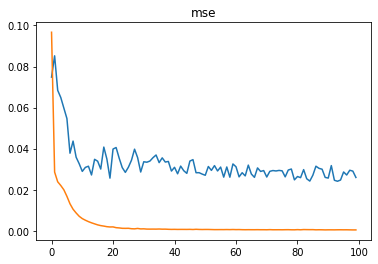

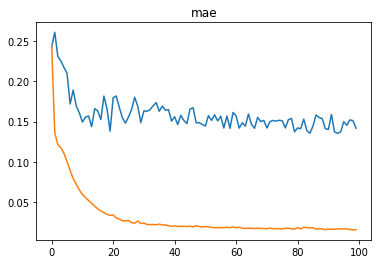

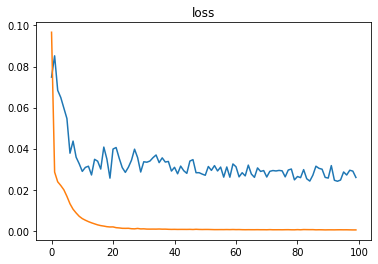

In [10]:
plt.plot(sim_conv_model.history.history['val_mse'])
plt.plot(sim_conv_model.history.history['mse'])
plt.title('mse')
plt.show()

plt.plot(sim_conv_model.history.history['val_mae'])
plt.plot(sim_conv_model.history.history['mae'])
plt.title('mae')
plt.show()

plt.plot(sim_conv_model.history.history['val_loss'])
plt.plot(sim_conv_model.history.history['loss'])
plt.title('loss')
plt.show()